In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

batch_size = 128
num_epochs = 100
seed = 1
out_dir = './vae_2'

In [2]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=True,
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train=False,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, 2)
        self.fc22 = nn.Linear(512, 2)
        
        self.fc3 = nn.Linear(2, 512)
        self.fc4 = nn.Linear(512, 784)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc21(h), self.fc22(h)
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        h = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h))
    
    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
model = VAE()
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def loss_function(recon_x, x, mu, logvar):
    recon = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon + kld

In [7]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if cuda:
            data = Variable(data.cuda())
        else:
            data = Variable(data)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
    
    # loss_function() は平均ではなく全サンプルの合計lossを返すのでサンプル数で割る
    train_loss /= len(train_loader.dataset)

    return train_loss    
    

def test(epoch):
    model.eval()
    test_loss = 0
    for batch_idx, (data, _) in enumerate(test_loader):
        if cuda:
            data = Variable(data.cuda(), volatile=True)
        else:
            data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        test_loss += loss.data[0]
        
        if epoch % 10 == 0:
            # 10エポックごとに最初のminibatchの入力画像と復元画像を保存
            if batch_idx == 0:
                n = 8
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.data.cpu(),
                           '{}/reconstruction_{}.png'.format(out_dir, epoch), nrow=n)

    test_loss /= len(test_loader.dataset)

    return test_loss

loss_list = []
test_loss_list = []
for epoch in range(1, num_epochs + 1):
    loss = train(epoch)
    test_loss = test(epoch)

    print('epoch [{}/{}], loss: {:.4f} test_loss: {:.4f}'.format(
        epoch,
        num_epochs,
        loss,
        test_loss))

    # logging
    loss_list.append(loss)
    test_loss_list.append(test_loss)

# save the training model
np.save('loss_list.npy', np.array(loss_list))
np.save('test_loss_list.npy', np.array(test_loss_list))
torch.save(model.state_dict(), 'vae.pth')

epoch [2/100], loss: 187.8114 test_loss: 168.1929
epoch [3/100], loss: 166.7456 test_loss: 163.0554
epoch [4/100], loss: 162.5757 test_loss: 160.2616
epoch [5/100], loss: 160.1674 test_loss: 158.3441
epoch [6/100], loss: 158.5233 test_loss: 156.7854
epoch [7/100], loss: 157.1654 test_loss: 155.8838
epoch [8/100], loss: 156.0256 test_loss: 154.6146
epoch [9/100], loss: 155.0083 test_loss: 154.3667
epoch [10/100], loss: 154.1859 test_loss: 153.4700
epoch [11/100], loss: 153.4215 test_loss: 152.6026
epoch [12/100], loss: 152.8147 test_loss: 152.2625
epoch [13/100], loss: 152.2212 test_loss: 151.7226
epoch [14/100], loss: 151.7127 test_loss: 151.6620
epoch [15/100], loss: 151.2089 test_loss: 151.2056
epoch [16/100], loss: 150.7898 test_loss: 150.8706
epoch [17/100], loss: 150.4091 test_loss: 150.8214
epoch [18/100], loss: 150.0285 test_loss: 150.3587
epoch [19/100], loss: 149.6594 test_loss: 150.3466
epoch [20/100], loss: 149.3560 test_loss: 150.2400
epoch [21/100], loss: 149.0927 test_los

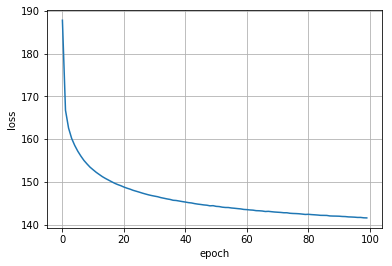

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_list = np.load('./loss_list.npy')
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

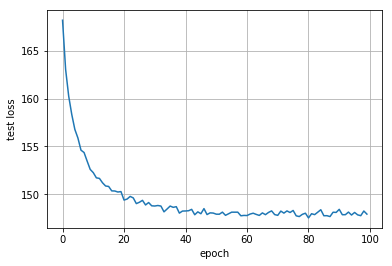

In [10]:
test_loss_list = np.load('./test_loss_list.npy')
plt.plot(test_loss_list)
plt.xlabel('epoch')
plt.ylabel('test loss')
plt.grid()

In [11]:
model.load_state_dict(torch.load('./vae.pth',
                                 map_location=lambda storage,
                                 loc: storage))
test_dataset = datasets.MNIST('./data', download=True, train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)
images, labels = iter(test_loader).next()
images = images.view(10000, -1)

# 784次元ベクトルを2次元ベクトルにencode
z = model.encode(Variable(images, volatile=True))
mu, logvar = z
mu, logvar = mu.data.numpy(), logvar.data.numpy()
print(mu.shape, logvar.shape)

(10000, 2) (10000, 2)


In [12]:
import pylab

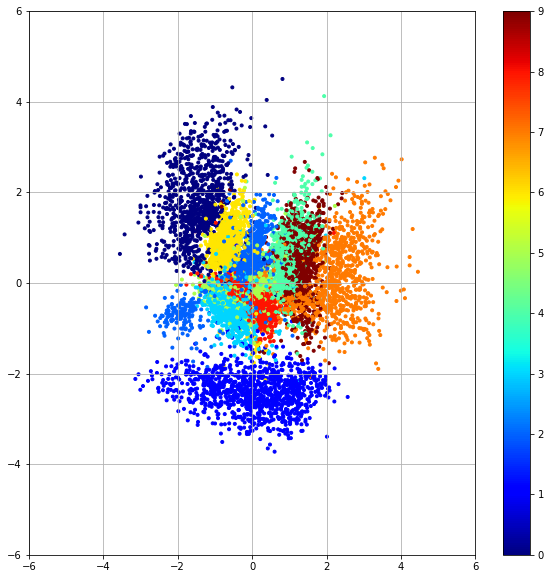

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.xlim((-6, 6))
plt.ylim((-6, 6))
plt.grid()